In [1]:
!ls

logins.json		      ultimate_data_science_challenge.pdf
ultimate_data_challenge.json  Untitled.ipynb


In [5]:
DATAPATH = ''
FILENAME = 'logins.json'

In [87]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf
from itertools import cycle, islice

In [16]:
# Experimentation shows file contains only one line
#  which consists of a single list of timestamps
maxlines = 3
with open(DATAPATH+FILENAME) as fi:
    for i, line in enumerate(fi):
        r = json.loads(line)
        print(r.keys())
        datum = r['login_time']
        print(type(datum), len(datum))
        print('start of line: ', datum[:3])
        print('end of line:   ', datum[-3:])
        if i>=maxlines: break
i

dict_keys(['login_time'])
<class 'list'> 93142
start of line:  ['1970-01-01 20:13:18', '1970-01-01 20:16:10', '1970-01-01 20:16:37']
end of line:    ['1970-04-13 18:54:02', '1970-04-13 18:57:38', '1970-04-13 18:54:23']


0

**Apparent problem: The data begin in 1970. There was no rideshare industry in 1970, so it's unlikely that Ultimate even existed, let alone had "user logins."  1970-01-01 is commonly used as a base date, so it seems likely that data have been written from a format in which a different base date was intended (maybe a problem writing a CSV from Excel).**

In [126]:
# Sanity check to make sure the json looks the way it should
with open(DATAPATH+FILENAME) as fi:
    line = fi.readline()
    print(line[:60])
    print(line[-60:])

{"login_time": ["1970-01-01 20:13:18", "1970-01-01 20:16:10"
13 18:54:02", "1970-04-13 18:57:38", "1970-04-13 18:54:23"]}


In [124]:
# Read timestamps
with open(DATAPATH+FILENAME) as fi:
    times = pd.Series(json.loads(fi.readline())['login_time'], dtype='datetime64[ns]')
print(times.shape)
times.head()

(93142,)


0   1970-01-01 20:13:18
1   1970-01-01 20:16:10
2   1970-01-01 20:16:37
3   1970-01-01 20:16:36
4   1970-01-01 20:26:21
dtype: datetime64[ns]

Minor problem (see below): the timestamps are not in chronological order.  (Presumably there was a variable lag in recording them.)  This is easily fixed, however.

In [33]:
# Why are the timestamps not in order?
s = times.sort_values()
print(s.equals(times))
s.head()

False


6   1970-01-01 20:12:16
0   1970-01-01 20:13:18
1   1970-01-01 20:16:10
3   1970-01-01 20:16:36
2   1970-01-01 20:16:37
dtype: datetime64[ns]

In [79]:
s.tail()

93136   1970-04-13 18:48:52
93137   1970-04-13 18:50:19
93139   1970-04-13 18:54:02
93141   1970-04-13 18:54:23
93140   1970-04-13 18:57:38
dtype: datetime64[ns]

Now we aggreagte.

In [48]:
# Aggregate at 15 minute intervals
filler = len(s)*[0]
df = pd.DataFrame(filler, index=s, columns=['n']).resample('15min').count()
print(df.shape, df.n.sum())
df.head()

(9788, 1) 93142


,n
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


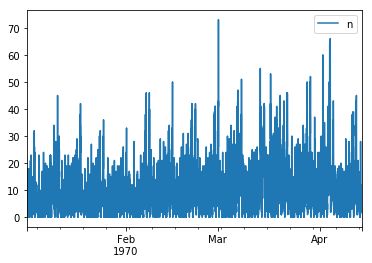

In [52]:
df.plot()
plt.show()

Let's look at the autocorrelation function to get an idea of the time structure of the data.

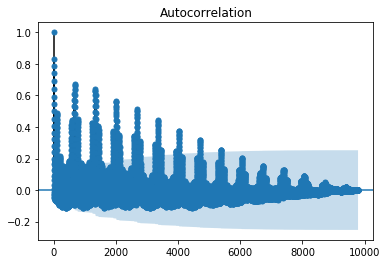

In [70]:
plot_acf(df.n)
plt.show()

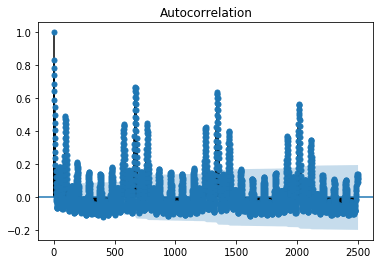

In [72]:
plot_acf(df.n, lags=2500)
plt.show()

Obviously there is a lot of cyclical activity, as indicated by the strong peaks in the autocorrelogram.  Let's look for cycles at specific frequencies that make sense in terms of real time.

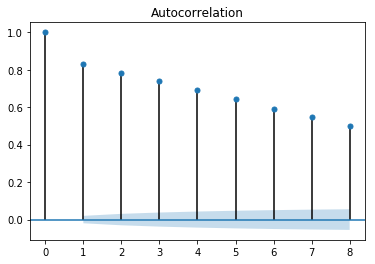

In [173]:
# No evidence of an hourly cycle (lag=4)
plot_acf(df.n, lags=8)
plt.show()

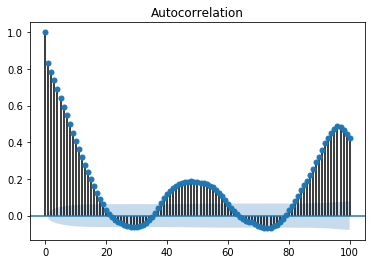

In [73]:
# Clear 12-hour (lag=48) and 24-hour (lag=96) cycle
plot_acf(df.n, lags=100)
plt.show()

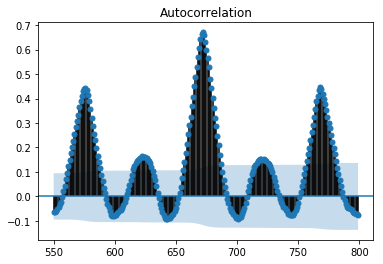

In [77]:
# weekly cycle (lag=672), also 6-day and 8-day cycle (presumably as a result of weekends)
plot_acf(df.n, lags=np.arange(550,800))
plt.show()

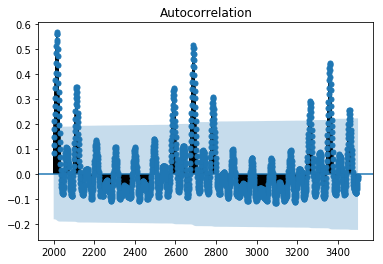

In [78]:
# No evidence (so far) of a monthly cycle (but hard to tell with only 3 1/2 months of data)
plot_acf(df.n, lags=np.arange(2000,3500))
plt.show()

So clearly there are weekly and daily cycles, and there appears also to be a half-daily cycle.  Also there is a suggestion that weekends behave differently from weekdays. (The behavior appears as 6-day Sunday-to-Saturday cycle and an 8-day Saturday-to-Sunday cycle.)

Let's aggregate the weekly cycles over time, so we can get an idea of the overall shape of the weekly cycle.

In [100]:
onehour = 4
halfday = 12*onehour
oneday = 24*onehour
oneweek = 7*oneday

# Create array of integers represnting how far into each cycle each observation is
def cycles(nobs_per_cycle, start, nobs_tot=len(df)):  
    return(np.array([*islice(cycle(range(nobs_per_cycle)), start, nobs_tot)]))

# For example
cycles(onehour, 20)

array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])

In [175]:
# Assume initially that the days of week are correct
starttime = df.n.index[0]
starttime, starttime.weekday(), starttime.hour

(Timestamp('1970-01-01 20:00:00', freq='15T'), 3, 20)

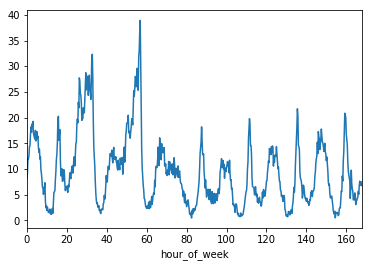

In [174]:
df['hour_of_week'] = cycles(oneweek)/onehour
weekly_cycle = df.groupby('hour_of_week').n.mean()
weekly_cycle.plot()

The weekly cycle confirms my initial suspicion that the dates are wrong. If we take the data at face value, there is a weekly cycle in which Thursday and Friday are the unusual ones, while Wednesday and Saturday look slightly unusual, and Sunday, Monday, and Tuesday look generic.  That pattern is not consistent with the expected rhythm of the 7-day week in our culture.  Looking more closely, we can see that there are five specific times in the week when demand suddenly increases and two times when it suddenly decreases.  If we assume that the former are near the beginnings of work days while the latter are near the end of weekend nights, then the pattern makes sense, and it appears that the data begin on Thursday rather than Wednesday. 

Under the assumption that the data do begin on Thursday, the weekends (from 5PM Friday to 11PM Sunday) look like this:

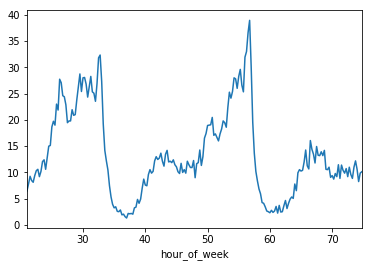

In [176]:
weekly_cycle.iloc[oneday-3*onehour:3*onehour+3*oneday].plot()
plt.show()

...and the weekdays (from 11PM Sunday to 5PM Friday) look like this:

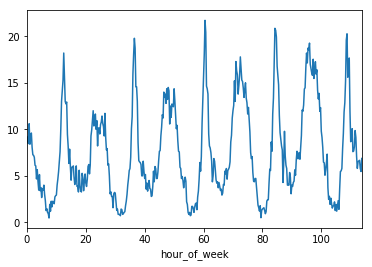

In [177]:
start_cycle = weekly_cycle.iloc[3*onehour+3*oneday:]
end_cycle = weekly_cycle.iloc[:oneday-3*onehour]
start_cycle.index = start_cycle.index - 3 - 3*24
end_cycle.index = end_cycle.index + (4*24 - 3)
shifted_cycle = pd.concat([start_cycle, end_cycle])
shifted_cycle.plot()
plt.show()

In [178]:
shifted_cycle.values[9*onehour:12*onehour] # 8AM to 11AM Monday

array([ 2.2       ,  2.        ,  2.73333333,  2.86666667,  2.93333333,
        4.        ,  4.66666667,  5.46666667,  6.6       ,  7.6       ,
       10.        , 13.        ])

In [182]:
shifted_cycle.values[9*onehour+oneday:12*onehour+oneday] # 8AM to 11AM Tuesday

array([ 1.07142857,  1.14285714,  1.78571429,  2.28571429,  3.        ,
        4.        ,  4.71428571,  5.57142857,  5.78571429,  7.        ,
       10.07142857, 11.35714286])

In [163]:
weekly_cycle.index

Float64Index([   0.0,   0.25,    0.5,   0.75,    1.0,   1.25,    1.5,   1.75,
                 2.0,   2.25,
              ...
               165.5, 165.75,  166.0, 166.25,  166.5, 166.75,  167.0, 167.25,
               167.5, 167.75],
             dtype='float64', name='hour_of_week', length=672)

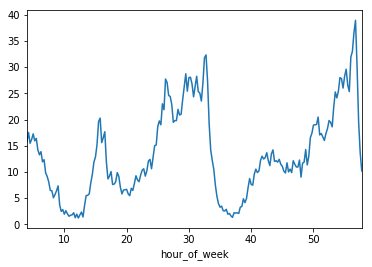

In [180]:
# Friday until 6AM Sunday morning
weekly_cycle.iloc[4*onehour:4*onehour+2*oneday+6*onehour].plot()
plt.show()

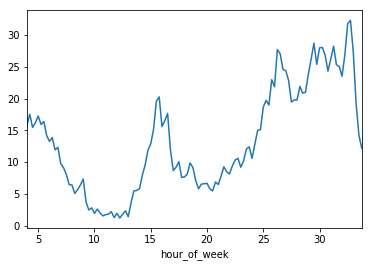

In [181]:
# Friday until 6AM Saturday morning
weekly_cycle.iloc[4*onehour:4*onehour+oneday+6*onehour].plot()
plt.show()

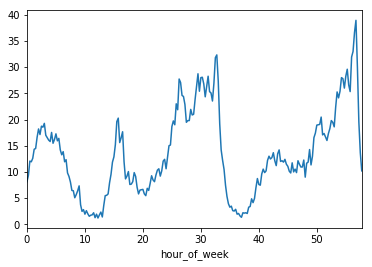

In [141]:
# 8PM Friday until 6AM Monday
weekly_cycle.iloc[:4*onehour+2*oneday+6*onehour].plot()
plt.show()

So assuming the *times of day* in the data are correct (a suspect assumption since the days of the week are clearly not), there is a rapid drop in ridership that occurs just before 6AM on Sunday and Monday mornings and a rapid increase in ridership that occurs between 9AM and Noon on weekdays.

This sort of makes sense.  On Friday and Saturday nights, people want rideshares at all times of night:  many have been drinking and haven't made clear plans about transportation beforehand.  I'm a little surprised the drop occurs so late in the morning (after 5AM, rather than, say, 2AM), but maybe a lot of people stay out very late.  It does seem likely that the later people stay out, the less likely they will have made transportaiton plans beforehand, so the need for rideshares might remain high for very late carousers.

On weekdays, a lot of transportation activity occurs before 9AM, but most of this is *planned well beforehand*.  You don't get a rideshare to get to work:  you take the bus, or the train, or your own car.  The transoportation activity that occurs during the workday is less likely to have been clearly planned beforehand and therefore more likely to require rideshares.

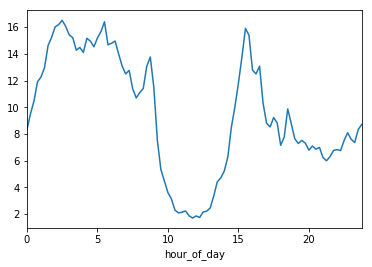

In [111]:
df['hour_of_day'] = cycles(oneday)/onehour
daily_cycle = df.groupby('hour_of_day').n.mean()
daily_cycle.plot()
plt.show()

In [57]:
f, t, Sxx = signal.spectrogram(df.n)
f.shape, t.shape, Sxx.shape

((129,), (43,), (129, 43))

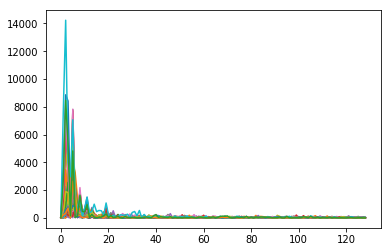

In [58]:
plt.plot(Sxx)
plt.show()

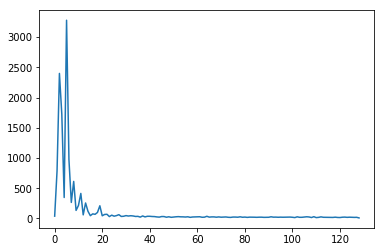

In [61]:
plt.plot(Sxx.mean(axis=1))
plt.show()

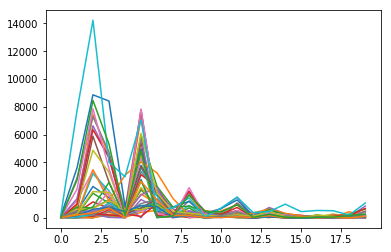

In [60]:
plt.plot(Sxx[:20])
plt.show()

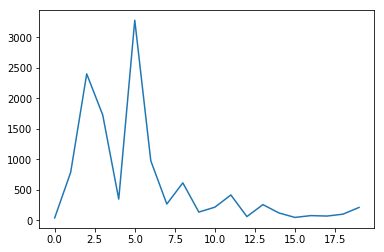

In [62]:
plt.plot(Sxx[:20].mean(axis=1))
plt.show()

In [65]:
Sxx.mean(axis=1)

array([  38.1563299 ,  785.85429881, 2398.81866073, 1725.6282693 ,
        346.72883289, 3278.17643464,  975.51816638,  265.27931624,
        612.75114895,  133.63944021,  214.2145449 ,  414.03427987,
         59.80110577,  256.04110089,  119.47805354,   46.16235148,
         76.13227155,   68.61336672,   99.64093188,  209.93994129,
         44.65283641,   66.41572073,   69.17005305,   31.29248962,
         54.66635803,   37.81289424,   47.33662824,   62.89783912,
         33.61799257,   36.60066055,   47.30460352,   40.25837559,
         45.25383452,   41.46301577,   33.23179974,   35.05084983,
         22.62889665,   41.69005187,   26.10144247,   36.27241681,
         36.04856897,   32.44794176,   31.10700234,   25.52036566,
         22.32922237,   31.94467048,   31.56019946,   20.6465326 ,
         28.08016678,   19.24304642,   24.17089594,   27.67814172,
         30.38076164,   27.16696352,   26.55170804,   23.84549375,
         27.96033203,   18.6307937 ,   24.43996941,   25.20026

In [66]:
f

array([0.        , 0.00390625, 0.0078125 , 0.01171875, 0.015625  ,
       0.01953125, 0.0234375 , 0.02734375, 0.03125   , 0.03515625,
       0.0390625 , 0.04296875, 0.046875  , 0.05078125, 0.0546875 ,
       0.05859375, 0.0625    , 0.06640625, 0.0703125 , 0.07421875,
       0.078125  , 0.08203125, 0.0859375 , 0.08984375, 0.09375   ,
       0.09765625, 0.1015625 , 0.10546875, 0.109375  , 0.11328125,
       0.1171875 , 0.12109375, 0.125     , 0.12890625, 0.1328125 ,
       0.13671875, 0.140625  , 0.14453125, 0.1484375 , 0.15234375,
       0.15625   , 0.16015625, 0.1640625 , 0.16796875, 0.171875  ,
       0.17578125, 0.1796875 , 0.18359375, 0.1875    , 0.19140625,
       0.1953125 , 0.19921875, 0.203125  , 0.20703125, 0.2109375 ,
       0.21484375, 0.21875   , 0.22265625, 0.2265625 , 0.23046875,
       0.234375  , 0.23828125, 0.2421875 , 0.24609375, 0.25      ,
       0.25390625, 0.2578125 , 0.26171875, 0.265625  , 0.26953125,
       0.2734375 , 0.27734375, 0.28125   , 0.28515625, 0.28906